## Step 1: Load package and hydra configurations

In [1]:
import sys
sys.path.append("..")
from hydra import compose, initialize
import os
import transformers
import json
from accelerate import Accelerator
from accelerate.utils import set_seed
from transformers import AutoTokenizer, PretrainedConfig
from peft import LoraConfig, get_peft_model, PeftModel
import cv2
import diffusers
from diffusers import (
    AutoencoderKL,
    DDPMScheduler,
    UNet2DConditionModel,
)
from PIL import Image
from dataset import *
import matplotlib.pyplot as plt
import warnings
from DreamBooth_melo.trainer.melo_trainer import *
from DreamBooth_melo.database.router import *
os.environ['http_proxy'] = '127.0.0.1:7890'
os.environ['https_proxy'] = '127.0.0.1:7890'
import numpy as np
import random
random.seed(1)
# Load Configurations governed by hydra
initialize(version_base=None, config_path="config")
config = compose(config_name="config")
print(OmegaConf.to_yaml(config))

alg: melo_diff
train_text_encoder: true
learning_rate: 1.0e-05
validation_prompt: a photo of {} in the Acropolis
task: diffusion
pretrained_model_name_or_path: CompVis/stable-diffusion-v1-4
pretrained_cache_dir: pretrained_stable_diffusion
revision: null
tokenizer_name: null
class_data_dir: class_data
instance_prompt: a photo of
class_prompt: a photo of
with_prior_preservation: false
prior_loss_weight: 0.1
num_class_images: 40
seed: null
resolution: 512
center_crop: false
train_batch_size: 1
sample_batch_size: 4
num_train_epochs: 1
max_train_steps: 800
checkpoints_total_limit: null
resume_from_checkpoint: null
gradient_accumulation_steps: 1
gradient_checkpointing: false
scale_lr: false
lr_scheduler: constant
lr_warmup_steps: 0
lr_num_cycles: 1
lr_power: 1.0
use_8bit_adam: false
dataloader_num_workers: 0
adam_beta1: 0.9
adam_beta2: 0.999
adam_weight_decay: 0.01
adam_epsilon: 1.0e-08
max_grad_norm: 1.0
push_to_hub: false
hub_token: null
hub_model_id: null
allow_tf32: true
num_validation_

/home/yu/anaconda3/envs/melo_v2/lib/python3.9/site-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'config': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)


## Step 2: Functions for Evaluating Multi-MELO 

In [2]:
def import_model_class_from_model_name_or_path(pretrained_model_name_or_path: str, revision: str):
    text_encoder_config = PretrainedConfig.from_pretrained(
        pretrained_model_name_or_path,
        subfolder="text_encoder",
        revision=revision,
    )
    model_class = text_encoder_config.architectures[0]

    if model_class == "CLIPTextModel":
        from transformers import CLIPTextModel

        return CLIPTextModel
    elif model_class == "RobertaSeriesModelWithTransformation":
        from diffusers.pipelines.alt_diffusion.modeling_roberta_series import RobertaSeriesModelWithTransformation

        return RobertaSeriesModelWithTransformation
    elif model_class == "T5EncoderModel":
        from transformers import T5EncoderModel

        return T5EncoderModel
    else:
        raise ValueError(f"{model_class} is not supported.")

def unwrap_peft(input_model):
    if input_model.__class__.__name__ == "PeftModel":
        input_model = input_model.base_model.model
    return input_model

In [3]:
def plot_images(prompt, image_list):
    print(f"\033[31m{prompt}\033[0m")
    fig, axes = plt.subplots(1, len(image_list))

    for i in range(len(image_list)):
        img = image_list[i]
        axes[i].imshow(np.asarray(img)/255)
    
    fig.tight_layout()


def log_validation(
    text_encoder,
    tokenizer,
    unet,
    vae,
    args,
    device,
    weight_dtype,
    identifier_list,
    subject_list,
):
    pipeline_args = {}

    if vae is not None:
        pipeline_args["vae"] = vae

    block_index = 0

    for sub, iden in zip(subject_list, identifier_list):

        unet.reset_dynamic_mapping([block_index])
        text_encoder.reset_dynamic_mapping([block_index])


        # create pipeline (note: unet and vae are loaded again in float32)
        pipeline = DiffusionPipeline.from_pretrained(
            args.pretrained_model_name_or_path,
            tokenizer=tokenizer,
            text_encoder=unwrap_peft(text_encoder),
            unet=unwrap_peft(unet),
            revision=args.revision,
            torch_dtype=weight_dtype,
            safety_checker=None,
            **pipeline_args,
        )

        # We train on the simplified learning objective. If we were previously predicting a variance, we need the scheduler to ignore it
        scheduler_args = {}

        if "variance_type" in pipeline.scheduler.config:
            variance_type = pipeline.scheduler.config.variance_type

            if variance_type in ["learned", "learned_range"]:
                variance_type = "fixed_small"

            scheduler_args["variance_type"] = variance_type

        module = importlib.import_module("diffusers")
        scheduler_class = getattr(module, args.validation_scheduler)
        pipeline.scheduler = scheduler_class.from_config(pipeline.scheduler.config, **scheduler_args)
        pipeline = pipeline.to(device)
        pipeline.set_progress_bar_config(disable=True)


        instance_name = sub.replace("_"," ")
        generality_prompt_list = prompt_for_generality_test(iden, instance_name)
        generality_prompt_list = random.sample(generality_prompt_list, 1)
        for idx, prompt in enumerate(generality_prompt_list):
            pipeline_args = {"prompt": prompt}

            # run inference
            LOG.info(
                f"Running validation... \n Generating {args.num_validation_images} images with prompt:"
                f" {prompt}."
            )
            generator = None if args.seed is None else torch.Generator(device=device).manual_seed(args.seed)
            images = []
            if args.validation_images is None:
                for _ in range(args.num_validation_images):
                    with torch.autocast("cuda"):
                        image = pipeline(**pipeline_args, num_inference_steps=25, generator=generator).images[0]
                    images.append(image)
            else:
                for image in args.validation_images:
                    image = Image.open(image)
                    image = pipeline(**pipeline_args, image=image, generator=generator).images[0]
                    images.append(image)

            # folder = f"./generality/{sub}/prompt_id_{idx}"
            # if not os.path.exists(folder):
            #     os.makedirs(folder)
            # for i, img in enumerate(images):
            #     img.save(os.path.join(folder, f'{i}.jpg'))
            plot_images(prompt, images)
        block_index += 1

    del pipeline
    torch.cuda.empty_cache()

## Step 3: Load Diffusion Model and Incoporate Dynamic LoRA Blocks with Edited Knowledge

You are using a model of type clip_text_model to instantiate a model of type . This is not supported for all configurations of models and can yield errors.
/home/yu/anaconda3/envs/melo_v2/lib/python3.9/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


a zain backpack on top of pink fabric


Keyword arguments {'prompt': 'a zain backpack on top of pink fabric'} are not expected by StableDiffusionPipeline and will be ignored.


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


a photo of izz backpack dog on top of a dirt road


Keyword arguments {'prompt': 'a photo of izz backpack dog on top of a dirt road'} are not expected by StableDiffusionPipeline and will be ignored.


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


a photo of cube shaped rame bear plushie


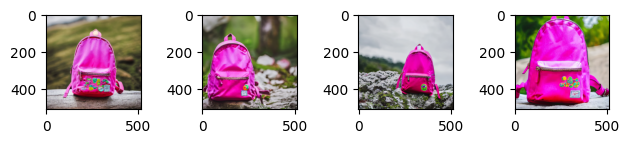

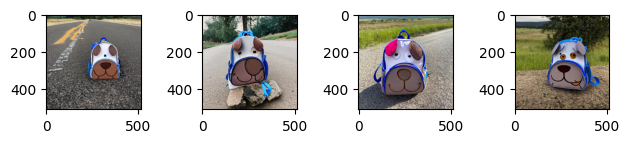

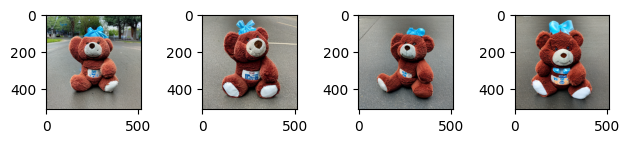

In [4]:
device = torch.device('cuda')
base_dir = '.'
checkpoint_dir = os.path.join(base_dir,"eval/checkpoint/MELO/text-inversion-model")


# import correct text encoder class
text_encoder_cls = import_model_class_from_model_name_or_path(config.pretrained_model_name_or_path,
                                                              config.revision)
# Load scheduler and models
noise_scheduler = DDPMScheduler.from_pretrained(config.pretrained_model_name_or_path, subfolder="scheduler")
text_encoder = text_encoder_cls.from_pretrained(
    config.pretrained_model_name_or_path, subfolder="text_encoder", revision=config.revision)
text_encoder = PeftModel.from_pretrained(text_encoder,model_id=os.path.join(checkpoint_dir,"text_encoder"))


vae = AutoencoderKL.from_pretrained(
    config.pretrained_model_name_or_path, subfolder="vae", revision=config.revision)

unet = UNet2DConditionModel.from_pretrained(
    config.pretrained_model_name_or_path, subfolder="unet", revision=config.revision)
unet = PeftModel.from_pretrained(unet,model_id=os.path.join(checkpoint_dir,"unet"))

# For mixed precision training we cast all non-trainable weights (vae, non-lora text_encoder and non-lora unet) to half-precision
# as these weights are only used for inference, keeping weights in full precision is not required.
weight_dtype = torch.float32


# Move vae and text_encoder to device and cast to weight_dtype
if vae is not None:
    vae.to(device, dtype=weight_dtype)

if text_encoder is not None:
    text_encoder.to(device, dtype=weight_dtype)

if unet is not None:
    unet.to(device, dtype=weight_dtype)





# Load the tokenizer
if config.tokenizer_name:
    tokenizer = AutoTokenizer.from_pretrained(config.tokenizer_name, revision=config.revision, use_fast=False)
elif config.pretrained_model_name_or_path:
    tokenizer = AutoTokenizer.from_pretrained(
        config.pretrained_model_name_or_path,
        subfolder="tokenizer",
        revision=config.revision,
        use_fast=False,
    )

with open(os.path.join(base_dir, "data", "data.json"), 'r') as f:
    data_info = json.load(f)
subject_list = list(data_info.keys())[:3]
identifier_list = np.load(os.path.join(base_dir, "data/rare_tokens/rare_tokens.npy"))[:len(subject_list)]

log_validation(
    text_encoder,
    tokenizer,
    unet,
    vae,
    config,
    device,
    weight_dtype,
    identifier_list,
    subject_list
)